In [1]:
from __future__ import division
from __future__ import print_function


import time
import argparse
import numpy as np
import pdb

import torch
import torch.nn.functional as F
import torch.optim as optim
import sys
import os

In [2]:
# pip install matplotlib==2.2.3

In [3]:
from pygcn.utils import load_data, accuracy
from pygcn.models import GCN

In [4]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from utils import load_data, accuracy
from models import GAT, SpGAT

# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda',
                    action='store_true',
                    default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode',
                    action='store_true',
                    default=False,
                    help='Validate during training pass.')
parser.add_argument('--sparse',
                    action='store_true',
                    default=False,
                    help='GAT with sparse version or not.')
parser.add_argument('--seed', type=int, default=72, help='Random seed.')
parser.add_argument('--epochs',
                    type=int,
                    default=10000,
                    help='Number of epochs to train.')
parser.add_argument('--lr',
                    type=float,
                    default=0.005,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay',
                    type=float,
                    default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden',
                    type=int,
                    default=8,
                    help='Number of hidden units.')
parser.add_argument('--nb_heads',
                    type=int,
                    default=8,
                    help='Number of head attentions.')
parser.add_argument('--dropout',
                    type=float,
                    default=0.6,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--alpha',
                    type=float,
                    default=0.2,
                    help='Alpha for the leaky_relu.')
parser.add_argument('--patience', type=int, default=100, help='Patience')
parser.add_argument('--best_epoch', type=int, default=0, help='best_epoch')

# args = parser.parse_args()
args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

# Model and optimizer
if args.sparse:
    model = SpGAT(nfeat=features.shape[1],
                  nhid=args.hidden,
                  nclass=int(labels.max()) + 1,
                  dropout=args.dropout,
                  nheads=args.nb_heads,
                  alpha=args.alpha)
else:
    model = GAT(nfeat=features.shape[1],
                nhid=args.hidden,
                nclass=int(labels.max()) + 1,
                dropout=args.dropout,
                nheads=args.nb_heads,
                alpha=args.alpha)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr,
                       weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

features, adj, labels = Variable(features), Variable(adj), Variable(labels)

Loading cora dataset...


In [8]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch + 1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val.data.item()


def compute_test():
    model.eval()
    output = model(features, adj)
    #     import pdb; pdb.set_trace()
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:", "loss= {:.4f}".format(loss_test.data),
          "accuracy= {:.4f}".format(acc_test.data))

In [9]:
# Train model
t_total = time.time()
loss_values = []
bad_counter = 0
best = args.epochs + 1
best_epoch = args.best_epoch
for epoch in range(args.epochs):
    loss_values.append(train(epoch))

    torch.save(model.state_dict(), '{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == args.patience:
        break

    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Restore best model

Epoch: 0001 loss_train: 3.1972 acc_train: 0.2857 loss_val: 2.6262 acc_val: 0.2867 time: 0.6668s
Epoch: 0002 loss_train: 3.1615 acc_train: 0.3357 loss_val: 2.5605 acc_val: 0.2867 time: 0.6655s
Epoch: 0003 loss_train: 2.5677 acc_train: 0.3714 loss_val: 2.5005 acc_val: 0.2900 time: 0.6599s
Epoch: 0004 loss_train: 2.8411 acc_train: 0.3714 loss_val: 2.4444 acc_val: 0.2900 time: 0.6627s
Epoch: 0005 loss_train: 2.7419 acc_train: 0.3643 loss_val: 2.3907 acc_val: 0.2900 time: 0.6634s
Epoch: 0006 loss_train: 2.9313 acc_train: 0.3071 loss_val: 2.3393 acc_val: 0.2867 time: 0.6646s
Epoch: 0007 loss_train: 2.5227 acc_train: 0.3714 loss_val: 2.2920 acc_val: 0.2867 time: 0.6624s
Epoch: 0008 loss_train: 2.8468 acc_train: 0.3429 loss_val: 2.2472 acc_val: 0.2867 time: 0.6596s
Epoch: 0009 loss_train: 2.5307 acc_train: 0.3500 loss_val: 2.2054 acc_val: 0.2867 time: 0.6606s
Epoch: 0010 loss_train: 2.4738 acc_train: 0.3071 loss_val: 2.1655 acc_val: 0.2900 time: 0.6663s
Epoch: 0011 loss_train: 2.3707 acc_train

Epoch: 0087 loss_train: 0.8670 acc_train: 0.7643 loss_val: 0.9442 acc_val: 0.7600 time: 0.6597s
Epoch: 0088 loss_train: 0.9779 acc_train: 0.7571 loss_val: 0.9395 acc_val: 0.7567 time: 0.6628s
Epoch: 0089 loss_train: 0.9278 acc_train: 0.7857 loss_val: 0.9348 acc_val: 0.7567 time: 0.6634s
Epoch: 0090 loss_train: 0.8526 acc_train: 0.7643 loss_val: 0.9301 acc_val: 0.7600 time: 0.6659s
Epoch: 0091 loss_train: 0.9217 acc_train: 0.7786 loss_val: 0.9256 acc_val: 0.7633 time: 0.6603s
Epoch: 0092 loss_train: 0.9178 acc_train: 0.8071 loss_val: 0.9214 acc_val: 0.7633 time: 0.6594s
Epoch: 0093 loss_train: 0.9567 acc_train: 0.7500 loss_val: 0.9171 acc_val: 0.7633 time: 0.6588s
Epoch: 0094 loss_train: 0.8352 acc_train: 0.7786 loss_val: 0.9128 acc_val: 0.7633 time: 0.6625s
Epoch: 0095 loss_train: 0.8141 acc_train: 0.7571 loss_val: 0.9084 acc_val: 0.7633 time: 0.6613s
Epoch: 0096 loss_train: 0.8327 acc_train: 0.7929 loss_val: 0.9041 acc_val: 0.7633 time: 0.6596s
Epoch: 0097 loss_train: 1.0366 acc_train

Epoch: 0173 loss_train: 0.6678 acc_train: 0.8786 loss_val: 0.7523 acc_val: 0.8133 time: 0.6638s
Epoch: 0174 loss_train: 0.6907 acc_train: 0.8357 loss_val: 0.7510 acc_val: 0.8167 time: 0.6610s
Epoch: 0175 loss_train: 0.6376 acc_train: 0.8571 loss_val: 0.7496 acc_val: 0.8167 time: 0.6629s
Epoch: 0176 loss_train: 0.7847 acc_train: 0.8429 loss_val: 0.7485 acc_val: 0.8167 time: 0.6621s
Epoch: 0177 loss_train: 0.7206 acc_train: 0.8214 loss_val: 0.7473 acc_val: 0.8167 time: 0.6628s
Epoch: 0178 loss_train: 0.7084 acc_train: 0.8500 loss_val: 0.7462 acc_val: 0.8167 time: 0.6591s
Epoch: 0179 loss_train: 0.6053 acc_train: 0.8571 loss_val: 0.7451 acc_val: 0.8167 time: 0.6901s
Epoch: 0180 loss_train: 0.7509 acc_train: 0.8214 loss_val: 0.7439 acc_val: 0.8167 time: 0.6886s
Epoch: 0181 loss_train: 0.6116 acc_train: 0.8857 loss_val: 0.7429 acc_val: 0.8200 time: 0.6642s
Epoch: 0182 loss_train: 0.7391 acc_train: 0.8071 loss_val: 0.7420 acc_val: 0.8200 time: 0.6618s
Epoch: 0183 loss_train: 0.7346 acc_train

Epoch: 0259 loss_train: 0.6699 acc_train: 0.8286 loss_val: 0.7057 acc_val: 0.8233 time: 0.6687s
Epoch: 0260 loss_train: 0.6372 acc_train: 0.8286 loss_val: 0.7055 acc_val: 0.8233 time: 0.6630s
Epoch: 0261 loss_train: 0.6249 acc_train: 0.8214 loss_val: 0.7054 acc_val: 0.8233 time: 0.6620s
Epoch: 0262 loss_train: 0.6763 acc_train: 0.8571 loss_val: 0.7052 acc_val: 0.8233 time: 0.6824s
Epoch: 0263 loss_train: 0.5986 acc_train: 0.8786 loss_val: 0.7051 acc_val: 0.8233 time: 0.6664s
Epoch: 0264 loss_train: 0.6743 acc_train: 0.8357 loss_val: 0.7051 acc_val: 0.8233 time: 0.6631s
Epoch: 0265 loss_train: 0.6427 acc_train: 0.8214 loss_val: 0.7047 acc_val: 0.8233 time: 0.6609s
Epoch: 0266 loss_train: 0.6822 acc_train: 0.8214 loss_val: 0.7044 acc_val: 0.8233 time: 0.6611s
Epoch: 0267 loss_train: 0.5981 acc_train: 0.8429 loss_val: 0.7040 acc_val: 0.8233 time: 0.6652s
Epoch: 0268 loss_train: 0.5410 acc_train: 0.8857 loss_val: 0.7035 acc_val: 0.8233 time: 0.6711s
Epoch: 0269 loss_train: 0.6932 acc_train

Epoch: 0345 loss_train: 0.6201 acc_train: 0.8643 loss_val: 0.6799 acc_val: 0.8267 time: 0.6694s
Epoch: 0346 loss_train: 0.6153 acc_train: 0.8357 loss_val: 0.6796 acc_val: 0.8267 time: 0.6782s
Epoch: 0347 loss_train: 0.6222 acc_train: 0.8429 loss_val: 0.6793 acc_val: 0.8267 time: 0.6649s
Epoch: 0348 loss_train: 0.6737 acc_train: 0.8214 loss_val: 0.6790 acc_val: 0.8267 time: 0.6657s
Epoch: 0349 loss_train: 0.6297 acc_train: 0.8571 loss_val: 0.6789 acc_val: 0.8200 time: 0.6641s
Epoch: 0350 loss_train: 0.5318 acc_train: 0.8857 loss_val: 0.6789 acc_val: 0.8200 time: 0.6631s
Epoch: 0351 loss_train: 0.6024 acc_train: 0.8571 loss_val: 0.6789 acc_val: 0.8167 time: 0.6834s
Epoch: 0352 loss_train: 0.6079 acc_train: 0.8500 loss_val: 0.6790 acc_val: 0.8167 time: 0.6646s
Epoch: 0353 loss_train: 0.5863 acc_train: 0.8143 loss_val: 0.6790 acc_val: 0.8167 time: 0.6613s
Epoch: 0354 loss_train: 0.6309 acc_train: 0.8143 loss_val: 0.6790 acc_val: 0.8167 time: 0.6658s
Epoch: 0355 loss_train: 0.6202 acc_train

Epoch: 0431 loss_train: 0.6307 acc_train: 0.8357 loss_val: 0.6728 acc_val: 0.8200 time: 0.6734s
Epoch: 0432 loss_train: 0.6372 acc_train: 0.8643 loss_val: 0.6722 acc_val: 0.8200 time: 0.6607s
Epoch: 0433 loss_train: 0.5953 acc_train: 0.8571 loss_val: 0.6714 acc_val: 0.8233 time: 0.6623s
Epoch: 0434 loss_train: 0.6242 acc_train: 0.8357 loss_val: 0.6706 acc_val: 0.8200 time: 0.6632s
Epoch: 0435 loss_train: 0.5562 acc_train: 0.8714 loss_val: 0.6698 acc_val: 0.8200 time: 0.6622s
Epoch: 0436 loss_train: 0.5751 acc_train: 0.8786 loss_val: 0.6690 acc_val: 0.8200 time: 0.6636s
Epoch: 0437 loss_train: 0.7009 acc_train: 0.8143 loss_val: 0.6681 acc_val: 0.8200 time: 0.6626s
Epoch: 0438 loss_train: 0.5713 acc_train: 0.8286 loss_val: 0.6671 acc_val: 0.8200 time: 0.6615s
Epoch: 0439 loss_train: 0.6178 acc_train: 0.8357 loss_val: 0.6662 acc_val: 0.8200 time: 0.6638s
Epoch: 0440 loss_train: 0.6481 acc_train: 0.8214 loss_val: 0.6656 acc_val: 0.8233 time: 0.6630s
Epoch: 0441 loss_train: 0.6295 acc_train

Epoch: 0517 loss_train: 0.5887 acc_train: 0.8714 loss_val: 0.6601 acc_val: 0.8200 time: 0.6666s
Epoch: 0518 loss_train: 0.5936 acc_train: 0.8643 loss_val: 0.6606 acc_val: 0.8200 time: 0.6613s
Epoch: 0519 loss_train: 0.6120 acc_train: 0.8286 loss_val: 0.6613 acc_val: 0.8200 time: 0.6620s
Epoch: 0520 loss_train: 0.6596 acc_train: 0.8214 loss_val: 0.6619 acc_val: 0.8233 time: 0.6635s
Epoch: 0521 loss_train: 0.6888 acc_train: 0.8214 loss_val: 0.6622 acc_val: 0.8233 time: 0.6657s
Epoch: 0522 loss_train: 0.5893 acc_train: 0.8357 loss_val: 0.6628 acc_val: 0.8233 time: 0.6671s
Epoch: 0523 loss_train: 0.6863 acc_train: 0.8143 loss_val: 0.6631 acc_val: 0.8233 time: 0.6635s
Epoch: 0524 loss_train: 0.5455 acc_train: 0.8643 loss_val: 0.6633 acc_val: 0.8233 time: 0.6687s
Epoch: 0525 loss_train: 0.5560 acc_train: 0.8714 loss_val: 0.6633 acc_val: 0.8233 time: 0.6658s
Epoch: 0526 loss_train: 0.5776 acc_train: 0.8429 loss_val: 0.6635 acc_val: 0.8233 time: 0.6647s
Epoch: 0527 loss_train: 0.5691 acc_train

Epoch: 0603 loss_train: 0.7246 acc_train: 0.8000 loss_val: 0.6482 acc_val: 0.8300 time: 0.6872s
Epoch: 0604 loss_train: 0.5215 acc_train: 0.9071 loss_val: 0.6483 acc_val: 0.8300 time: 0.6763s
Epoch: 0605 loss_train: 0.5459 acc_train: 0.8429 loss_val: 0.6484 acc_val: 0.8300 time: 0.6599s
Epoch: 0606 loss_train: 0.6171 acc_train: 0.8643 loss_val: 0.6484 acc_val: 0.8300 time: 0.6700s
Epoch: 0607 loss_train: 0.6185 acc_train: 0.8214 loss_val: 0.6484 acc_val: 0.8300 time: 0.6779s
Epoch: 0608 loss_train: 0.5901 acc_train: 0.8357 loss_val: 0.6485 acc_val: 0.8300 time: 0.6711s
Epoch: 0609 loss_train: 0.5855 acc_train: 0.8571 loss_val: 0.6488 acc_val: 0.8300 time: 0.6672s
Epoch: 0610 loss_train: 0.7421 acc_train: 0.8286 loss_val: 0.6491 acc_val: 0.8300 time: 0.6852s
Epoch: 0611 loss_train: 0.5943 acc_train: 0.8500 loss_val: 0.6496 acc_val: 0.8300 time: 0.6670s
Epoch: 0612 loss_train: 0.5353 acc_train: 0.8786 loss_val: 0.6500 acc_val: 0.8267 time: 0.6737s
Epoch: 0613 loss_train: 0.5224 acc_train

Epoch: 0689 loss_train: 0.5580 acc_train: 0.8357 loss_val: 0.6489 acc_val: 0.8233 time: 0.6819s
Epoch: 0690 loss_train: 0.5803 acc_train: 0.8643 loss_val: 0.6501 acc_val: 0.8233 time: 0.6609s
Epoch: 0691 loss_train: 0.5617 acc_train: 0.8643 loss_val: 0.6512 acc_val: 0.8233 time: 0.6617s
Epoch: 0692 loss_train: 0.5289 acc_train: 0.8857 loss_val: 0.6519 acc_val: 0.8233 time: 0.6655s
Epoch: 0693 loss_train: 0.5984 acc_train: 0.8214 loss_val: 0.6525 acc_val: 0.8233 time: 0.6603s
Epoch: 0694 loss_train: 0.6093 acc_train: 0.8500 loss_val: 0.6530 acc_val: 0.8233 time: 0.6614s
Epoch: 0695 loss_train: 0.4503 acc_train: 0.8857 loss_val: 0.6533 acc_val: 0.8233 time: 0.6696s
Epoch: 0696 loss_train: 0.6106 acc_train: 0.8571 loss_val: 0.6535 acc_val: 0.8233 time: 0.6610s
Epoch: 0697 loss_train: 0.6440 acc_train: 0.8286 loss_val: 0.6538 acc_val: 0.8233 time: 0.6675s
Epoch: 0698 loss_train: 0.5738 acc_train: 0.8786 loss_val: 0.6542 acc_val: 0.8233 time: 0.6654s
Epoch: 0699 loss_train: 0.4893 acc_train

Epoch: 0775 loss_train: 0.6694 acc_train: 0.7929 loss_val: 0.6481 acc_val: 0.8233 time: 0.6620s
Epoch: 0776 loss_train: 0.5843 acc_train: 0.8500 loss_val: 0.6484 acc_val: 0.8233 time: 0.6680s
Epoch: 0777 loss_train: 0.6240 acc_train: 0.8429 loss_val: 0.6487 acc_val: 0.8200 time: 0.6603s
Epoch: 0778 loss_train: 0.5946 acc_train: 0.8357 loss_val: 0.6492 acc_val: 0.8167 time: 0.6638s
Epoch: 0779 loss_train: 0.4727 acc_train: 0.8857 loss_val: 0.6496 acc_val: 0.8167 time: 0.6647s
Epoch: 0780 loss_train: 0.6186 acc_train: 0.8429 loss_val: 0.6499 acc_val: 0.8167 time: 0.6597s
Epoch: 0781 loss_train: 0.7283 acc_train: 0.8143 loss_val: 0.6504 acc_val: 0.8167 time: 0.6913s
Epoch: 0782 loss_train: 0.6887 acc_train: 0.8143 loss_val: 0.6507 acc_val: 0.8200 time: 0.6629s
Epoch: 0783 loss_train: 0.5976 acc_train: 0.8714 loss_val: 0.6509 acc_val: 0.8267 time: 0.6617s
Epoch: 0784 loss_train: 0.5892 acc_train: 0.8643 loss_val: 0.6513 acc_val: 0.8233 time: 0.6611s
Epoch: 0785 loss_train: 0.6120 acc_train

Epoch: 0861 loss_train: 0.5923 acc_train: 0.8071 loss_val: 0.6498 acc_val: 0.8200 time: 0.6586s
Epoch: 0862 loss_train: 0.6108 acc_train: 0.8429 loss_val: 0.6504 acc_val: 0.8200 time: 0.6628s
Epoch: 0863 loss_train: 0.7096 acc_train: 0.7786 loss_val: 0.6510 acc_val: 0.8200 time: 0.6620s
Epoch: 0864 loss_train: 0.5643 acc_train: 0.8857 loss_val: 0.6516 acc_val: 0.8200 time: 0.6618s
Epoch: 0865 loss_train: 0.6449 acc_train: 0.8429 loss_val: 0.6522 acc_val: 0.8200 time: 0.6645s
Epoch: 0866 loss_train: 0.5371 acc_train: 0.8857 loss_val: 0.6526 acc_val: 0.8167 time: 0.6672s
Epoch: 0867 loss_train: 0.5659 acc_train: 0.8500 loss_val: 0.6526 acc_val: 0.8167 time: 0.6652s
Epoch: 0868 loss_train: 0.7245 acc_train: 0.8000 loss_val: 0.6527 acc_val: 0.8167 time: 0.6605s
Epoch: 0869 loss_train: 0.6079 acc_train: 0.8286 loss_val: 0.6522 acc_val: 0.8167 time: 0.6694s
Epoch: 0870 loss_train: 0.5358 acc_train: 0.8500 loss_val: 0.6520 acc_val: 0.8167 time: 0.6637s
Epoch: 0871 loss_train: 0.5399 acc_train

Epoch: 0947 loss_train: 0.6321 acc_train: 0.8357 loss_val: 0.6484 acc_val: 0.8167 time: 0.6831s
Epoch: 0948 loss_train: 0.6017 acc_train: 0.8500 loss_val: 0.6485 acc_val: 0.8167 time: 0.6839s
Epoch: 0949 loss_train: 0.5859 acc_train: 0.8571 loss_val: 0.6485 acc_val: 0.8167 time: 0.7575s
Epoch: 0950 loss_train: 0.7044 acc_train: 0.8286 loss_val: 0.6482 acc_val: 0.8167 time: 0.6822s
Epoch: 0951 loss_train: 0.6522 acc_train: 0.8429 loss_val: 0.6480 acc_val: 0.8167 time: 0.7336s
Optimization Finished!
Total time elapsed: 637.4183s


In [11]:
# model.load_state_dict(torch.load('952.pkl',map_location='cuda'))
# model(features, adj)[0]
model.load_state_dict(torch.load(f'{best_epoch}.pkl'))
compute_test()

Test set results: loss= 0.6588 accuracy= 0.8480


In [12]:
ori_adj = adj.cpu().numpy()
ori_adj = np.where(ori_adj>0, 1 ,0)
np.save('cora_ori_adj', ori_adj)
import scipy.sparse as sp
import networkx as nx
sparse_adj = sp.csr_matrix(ori_adj)
graph = nx.from_scipy_sparse_matrix(sparse_adj)
np_labels = labels.cpu().numpy()

In [13]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels), preds
def test():
    model.eval()
    output = model(features, adj)
    # import pdb; pdb.set_trace()
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test, preds = accuracy(output[idx_test], labels[idx_test])  # 1000 nodes
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    return preds, output

preds, output = test()
cpu_label = labels.cpu().numpy()
cpu_idx_test = idx_test.cpu().numpy()
true = np.argwhere(cpu_label[idx_test.tolist()] == preds.cpu().numpy()).flatten().tolist()
false = list(set(cpu_idx_test).difference(true))

In [15]:
true = idx_test[np.argwhere(preds.cpu().numpy() == cpu_label[idx_test.tolist()]).flatten().tolist()].tolist()
false = list(set(idx_test.tolist()).difference(true))
false.sort()
print(len(false))

152


In [16]:
import networkx as nx
cora_graph = nx.Graph(ori_adj)

In [17]:
false
pygat_false = false
# np.save('pygat_153', np.array(false))

In [18]:
pygcn_false = np.load('/home/v-yulan/repo/gcn_analysis/gcn_181.npy').tolist()
# pygcn_false[:30]
intersect = set(pygat_false).intersection(pygcn_false)
intersect.__len__()

130

In [19]:
pygat_only = list(set(pygat_false).difference(intersect))
pygat_only.sort()
np.array(pygat_only)

array([ 662,  682,  706,  782,  790,  836,  853,  859,  879,  926, 1033,
       1090, 1104, 1135, 1173, 1174, 1236, 1260, 1396, 1415, 1430, 1458])

In [20]:
pygcn_only = list(set(pygcn_false).difference(intersect))
pygcn_only.sort()
np.array(pygcn_only).shape

(51,)

In [21]:
intersect = list(set(pygat_false).intersection(pygcn_false))
intersect.sort()
np.array(intersect).size

130

In [165]:
def bfs_queue(graph: nx.Graph, root, max_level=3, level=0):
    import collections
    queue, res = collections.deque([(root, 0)]), []
    nodes = set(res)
    while queue:
        node, level = queue.popleft()
        if level > max_level:
            break
        if node not in nodes:
            nodes.update([node])
            if len(res) < level+1:
                res.insert(level, [])
            res[level].append(node)
        for neighbor in list(graph[node]):
            try:
                if neighbor not in sum(res,[]):
                    queue.append([neighbor, level+1])
            except:
                import pdb; pdb.set_trace()
    return res, list(nodes)

def statistics(graph, nodes, level=6):
    from texttable import Texttable
    from tqdm import tqdm
    table = Texttable()
    table.set_deco(Texttable.HEADER)
    results = {}
#     table.set_cols_dtype(['t',  # text
#                               'f',  # float (decimal)
#                               'e',  # float (exponent)
#                               'i',  # integer
#                               'a']) # automatic
    stat = [['Node']]
    stat[0].extend([f'{i}-hop' for i in range(1,level+1)])
    for node in tqdm(nodes):
        res, nodes = bfs_queue(cora_graph, node, level)
        row = [node]
        for hop in range(1, level+1):
            if len(res) < hop+1:
                row.append(0)
            else:
                row.append(len(res[hop]))
        stat.append(row)
        results[node] = (res, nodes)
    table.add_rows(stat)
    print(table.draw())
    return results  
def get_colors(label_number: int, mode: str):
    import randomcolor
    rand_color = randomcolor.RandomColor()
    if mode == 'diff':
        colors = {'train': 'grey', 'pred_train': 'green', 'pred_false': 'r'}
    elif mode == 'raw':
        colors = dict([(i, j) for i, j in enumerate(
            rand_color.generate(count=label_number))])
    elif mode == 'train_test':
        colors = {'train': 'grey', 'test': 'black'}
    elif mode == 'error':
        colors = dict([(i, j) for i, j in enumerate(
            rand_color.generate(count=label_number))])
        colors.update({'root': 'black'})
    else:
        raise NotImplementedError
    return colors

from typing import Dict, Tuple, List, Sequence, Optional
def get_node_pos(labels: Optional[np.ndarray] = None, sg_nodes: List = None, idx_test: Optional[List] = None, mode='raw', predict: Optional[np.ndarray] = None) -> Dict:
    '''
    1. get the whole graph: raw
    2. train and test node
    3. right and wrong node
    '''
    if type(labels) is torch.Tensor:
        labels = labels.cpu().numpy()
    if type(predict) is torch.Tensor:
        predict = predict.cpu().numpy()

    node_pos = {}
    # np.argwhere(labels == label).flatten().tolist()})
    if mode == 'raw':
        if sg_nodes is not None:
            for label in set(labels[sg_nodes]):
                node_pos.update(
                    {label: [node for node in sg_nodes if labels[node] == label]})
        else:
            for label in set(labels):
                node_pos.update(
                    {label: np.argwhere(labels == label).flatten().tolist()})
    elif mode == 'error':
        root = sg_nodes[0]
        for label in set(labels[sg_nodes]):
            node_pos.update(
                {label: [node for node in sg_nodes if labels[node] == label]})
        print(node_pos)
        node_pos.update({'root': [root]})
                            
    elif mode == 'train_test':
        assert idx_test is not None and sg_nodes is not None
        test_sg_nodes = list(set(sg_nodes).intersection(idx_test))
        train_sg_nodes = list(set(sg_nodes).difference(test_sg_nodes))
        node_pos.update({'train': train_sg_nodes, 'test': test_sg_nodes})
        pass

    elif mode == 'diff':
        assert predict is not None and sg_nodes is not None and idx_test is not None
        test_sg_nodes = list(set(sg_nodes).intersection(idx_test))
        train_sg_nodes = list(set(sg_nodes).difference(test_sg_nodes))
        true = list(set(idx_test[np.argwhere(
            labels[idx_test] == predict).flatten().tolist()]).intersection(test_sg_nodes))
        false = list(set(test_sg_nodes).difference(true))
        node_pos.update(
            {'train': train_sg_nodes, 'pred_true': true, 'pred_false': false})

    else:
        raise NotImplementedError(f'mode: {mode} unrecognized')

    return node_pos

def plot_cluster(graph, node_pos, colors, pos, options={"node_size": 40, "alpha": 0.8},  figsize=(8, 6), spring_k=0.15, labels=None, border_edge_list=None):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=figsize, dpi=150, facecolor='w', edgecolor='k')
    for node_label in node_pos:
        nx.draw_networkx_nodes(
            graph, pos, nodelist=node_pos[node_label], node_color=colors[node_label], **options)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=0.5)
    if labels:
        nx.draw_networkx_labels(graph, pos, labels, font_size=5)
    if border_edge_list is not None:
        nx.draw_networkx_edges(graph,pos,edgelist=border_edge_list['regular'],width=1,alpha=0.5,edge_color="g")
        nx.draw_networkx_edges(graph,pos,edgelist=border_edge_list['false'],width=1,alpha=0.5,edge_color="r")
def get_1hop_neighbors_edges(adj, node,test_node, false_node):
    res = np.argwhere(adj[node]).flatten().tolist()
    res.remove(node)
    edge_dict = {'false': [[node, i] for i in res if i in false_node]}
    edge_dict.update({'regular': [[node, i] for i in res if i not in sum(edge_dict['false'], [])]})
    return res, edge_dict
def one_hop_n_class(node, labels, adj):
    one_hop_n = np.argwhere(ori_adj[node]).flatten().tolist()
    one_hop_n.remove(node)
    neighbor_class = {i:f'{labels[i]}:{i}' for i in one_hop_n}
    node_label = labels[node]
    from collections import Counter
    count = Counter(labels[one_hop_n])
    length = list(count.elements()).__len__()
    for ele in count:
        count[ele] = f'{count[ele]/length*100:.1f}%'
    return str(count), neighbor_class

In [ ]:
# np.save('pygat_only',np.array(pygat_only))
gpath_false = np.load('GeniePathLazy_512_5.npy')

In [222]:
gpath_false[:10]

array([504, 506, 509, 510, 518, 522, 523, 524, 525, 529])

In [ ]:
intersect[:10]

In [ ]:
gpath_only = list(set(intersect).difference(gpath_false))
gpath_only.sort()
gpath_only[:]

In [317]:
gp_gat_inter = list(set(pygat_false).intersection(gpath_false))
gp_gat_inter.sort()
print(gp_gat_inter.__len__() / gpath_false.__len__())

0.5304347826086957


In [ ]:
gp_gat_diff = list(set(pygat_false).difference(gpath_false))
gp_gat_diff.sort()
gp_gat_diff

In [250]:
gpath_true = set(idx_test.tolist()).difference(gpath_false)
gat_true = set(idx_test.tolist()).difference(pygat_false)
gpath_true

{500,
 501,
 502,
 503,
 505,
 507,
 508,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 519,
 520,
 521,
 526,
 527,
 528,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 569,
 570,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 583,
 585,
 586,
 588,
 589,
 591,
 592,
 593,
 594,
 595,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 605,
 606,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 617,
 618,
 619,
 620,
 621,
 623,
 626,
 627,
 628,
 629,
 630,
 633,
 635,
 636,
 637,
 638,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 660,
 661,
 663,
 664,
 665,
 666,
 671,
 672,
 673,
 674,
 675,
 676,
 678,
 679,
 680,
 681,
 684,
 685,
 687,
 688,
 689,
 691,
 696,
 697,
 699,
 701,
 703,
 704,
 705,
 707,
 708,
 710,
 712,
 713,
 714,
 715,
 716,
 717

In [262]:
gpath_true_add = set(gpath_true).difference(set(gpath_true).intersection(gat_true))
gpath_true_add
# gat_true_add = set(gat_true).difference(gpath_true)

{511,
 520,
 538,
 790,
 853,
 859,
 903,
 908,
 926,
 953,
 972,
 977,
 1019,
 1090,
 1104,
 1109,
 1134,
 1135,
 1143,
 1164,
 1173,
 1207,
 1236,
 1237,
 1306,
 1374,
 1396,
 1437,
 1454,
 1491}

In [270]:
gpath_false_add = set(gpath_false).difference(set(gpath_false).intersection(pygat_false))
gpath_false_add = list(gpath_false_add)
gpath_false_add.sort()

In [318]:
gp_gcn_inter = list(set(pygcn_false).intersection(gpath_false))
gp_gcn_inter.sort()
gp_gcn_inter.__len__() / gpath_false.__len__()

0.5565217391304348

In [268]:
false_gp_gat_add_info = statistics(cora_graph, list(gpath_false_add)[:30])

100%|██████████| 30/30 [00:52<00:00,  1.76s/it]

Node   1-hop   2-hop   3-hop   4-hop   5-hop   6-hop
1024   4       60      128     583     803     550  
529    3       0       0       0       0       0    
1049   3       16      203     388     598     593  
1055   3       8       115     220     799     718  
1071   3       16      203     388     598     593  
568    2       19      135     600     734     521  
1085   1       3       4       41      280     524  
1088   1       1       3       48      131     469  
582    4       20      239     368     665     561  
1096   1       5       170     252     472     639  
587    4       81      166     653     748     489  
1101   3       23      69      351     551     734  
1103   5       147     251     711     687     413  
1108   4       4       0       0       0       0    
1111   7       35      84      216     619     704  
1112   8       29      187     354     649     674  
1117   10      45      291     387     605     590  
616    4       17      48      234     484    

In [269]:
true_gp_gat_add_info # true add
false_gp_gat_add_info # false add

{903: ([[903],
   [1491, 1672],
   [851, 1390, 1605, 294, 696, 807, 899, 1352, 1564],
   [21,
    83,
    85,
    103,
    128,
    153,
    173,
    186,
    191,
    252,
    277,
    465,
    466,
    477,
    483,
    502,
    554,
    564,
    565,
    566,
    588,
    633,
    636,
    638,
    665,
    699,
    1353,
    1438,
    2430,
    2476,
    215,
    427,
    579,
    747,
    611,
    1565,
    2674,
    687,
    745],
   [438,
    567,
    1378,
    425,
    552,
    2368,
    471,
    63,
    162,
    575,
    2485,
    22,
    163,
    395,
    448,
    60,
    74,
    562,
    688,
    523,
    118,
    2027,
    2672,
    16,
    229,
    333,
    463,
    1645,
    1766,
    2409,
    2658,
    367,
    650,
    749,
    933,
    2536,
    167,
    306,
    446,
    875,
    1859,
    738,
    1841,
    2,
    34,
    57,
    82,
    92,
    239,
    244,
    283,
    295,
    305,
    385,
    410,
    478,
    492,
    548,
    601,
    621,
    644,
    671,


In [340]:
info = false_gp_gat_add_info
false = gpath_false
case = 529

In [341]:
border_edge = get_1hop_neighbors_edges(ori_adj, case, idx_test.tolist(), false)[1]

border_edge

hop=5
sub_node = sum([node_list for node_list in info[case][0][:hop]], [])
error_graph = cora_graph.subgraph(sub_node)
_, neighbor_class = one_hop_n_class(case, cpu_label, ori_adj)
labels = {case: f'error:{case}', **neighbor_class}

pos = nx.spring_layout(error_graph, k=0.15)

/home/v-yulan/.conda/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  
/home/v-yulan/.conda/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  edge_colors = (colorConverter.to_rgba(edge_color, alpha), )
/home/v-yulan/.conda/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  label = str(label)  # this will cause "1" and 1 to be labeled the same


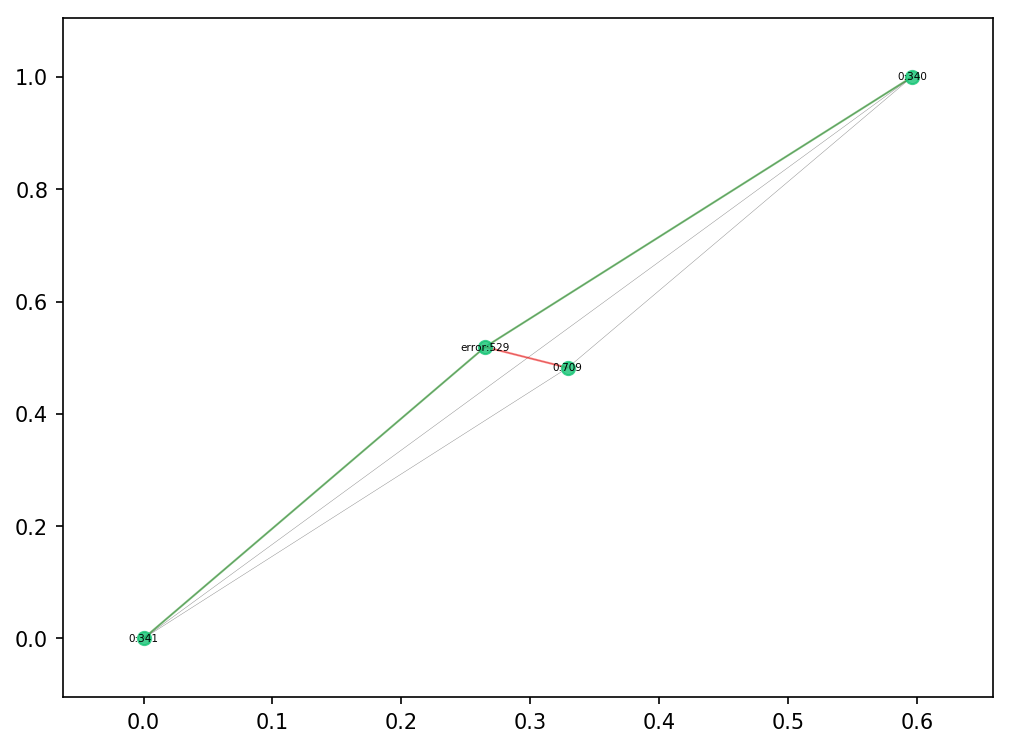

In [342]:
%matplotlib inline
class_node_pos = get_node_pos(np_labels, sub_node, idx_test.cpu().numpy(), mode='raw')
plot_cluster(error_graph, class_node_pos, class_colors, pos, labels=labels, border_edge_list=border_edge)

In [291]:
!pwd

/data/home/v-yulan/repo/gcn_analysis/models/pyGAT


In [147]:
np.argwhere(ori_adj[1104]).tolist()

[[1104], [1260], [1262]]

In [144]:
cpu_label[1104]

3

In [145]:
1104 in false

True

In [131]:
p = torch.softmax(output, 1)

In [159]:
p[1174]

tensor([0.0505, 0.1697, 0.0395, 0.2201, 0.2572, 0.0594, 0.2037],
       device='cuda:0', grad_fn=<SelectBackward>)

In [135]:
p[1198]

tensor([0.2032, 0.0873, 0.0706, 0.4127, 0.1242, 0.0498, 0.0522],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
# gcn embedding  1174

In [138]:
features.shape

torch.Size([2708, 1433])

In [154]:
features[1104]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [158]:
(features[1260] == features[1262]).sum()

tensor(1394, device='cuda:0')

In [208]:
cpu_label[500]

6

In [212]:
np.argwhere(ori_adj[0])

array([[  0],
       [  8],
       [ 14],
       [258],
       [435],
       [544]])

In [215]:
cpu_label[0]

0

In [216]:
!which python

/home/v-yulan/.conda/envs/py37/bin/python


In [338]:
(features[1024] == features[1053]).sum()

tensor(1395, device='cuda:0')

In [326]:
p[2165]

tensor([0.7153, 0.0095, 0.0100, 0.0109, 0.0107, 0.2020, 0.0417],
       device='cuda:0', grad_fn=<SelectBackward>)

In [339]:
features[1024,26]

tensor(0.0476, device='cuda:0')